# TensorFlow Tutorial #09
# Video Data

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

이전 튜토리얼 8은 전이학습이라 불리는 것으로 CIFAR-10 데이터셋에 대해 미리 학습된 인셉션 모델을 사용하는 법을 보였다. 이 튜토리얼은 자기 자신의 이미지를 사용하는 법을 보인다.

시연을 위해, 우리는 약간씩 다른 배경에서 칼, 스푼, 포크의 수천장의 이미지를 가진 [Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony)라 불리는 새로운 데이터셋을 사용한다. 학습 데이터셋은 4170장의 이미지이고 테스트셋은 530장의 이미지이다. 이 클래스의 이름은 심슨으로부터 가져온 knifey, spoony, forky 이다.

knifey-spoony 데이터셋안에 이미지는 리눅스에서 돌아가는 [script](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py) 를 사용해 비디오 파일로부터 만들어진다. (비디오로부터 이미지로 바꾸기 위해서는 `avconv` 프로그램이 필요하다). 몇분의 비디오로부터 수천장의 이미지인 데이터셋으로 쉽게 바꿀 수 있다.

이 튜토리얼은 이전 튜토리얼로부터 만들어지기 때문에 전이 학습에 대한 튜토리얼 8에 익숙해야한다.

## Flowchart

다음의 차트는 전이 학습에 인셉션 모델을 사용할 때 데이터가 어떻게 흐르는지 보여준다. 먼저 인셉션 모델에 넣고 이미지를 처리한다. 인셉션 모델의 최종 분류 레이어 전에, 전이 값이라 불리는 것을 캐쉬 파일에 저장한다

CIFAR-10 대신 Knifey-Spoony 데이터셋을 사용한다는 것을 제외하곤 이미지의 넘파일 배열 대신 인셉션 모델에 jpeg를 보내는 것을 의미하는 튜토리얼 8에서 했던 방법과 유사하다. 

새로운 데이터셋에 모든 이미지는 인셉션 모델을 통해 처리되고 그 결과 전이값은 캐쉬파일에 저장되면 또다른 신경망의 입력으로 전이값을 사용할 수 있다. 우리는 새로운 데이터셋으로부터 클래스를 사용해 두번째 신경망을 학습한 것이므로 신경망은 인셉션 모델로부터의 전이값에 기반하여 이미지를 분류하는 방법을 배운다

이 경우, 인셉션 모델은 이미지로부터의 유용한 정보를 추출하는 데에 사용되고 또다른 신경망은 실제 분류를 위해 사용된다

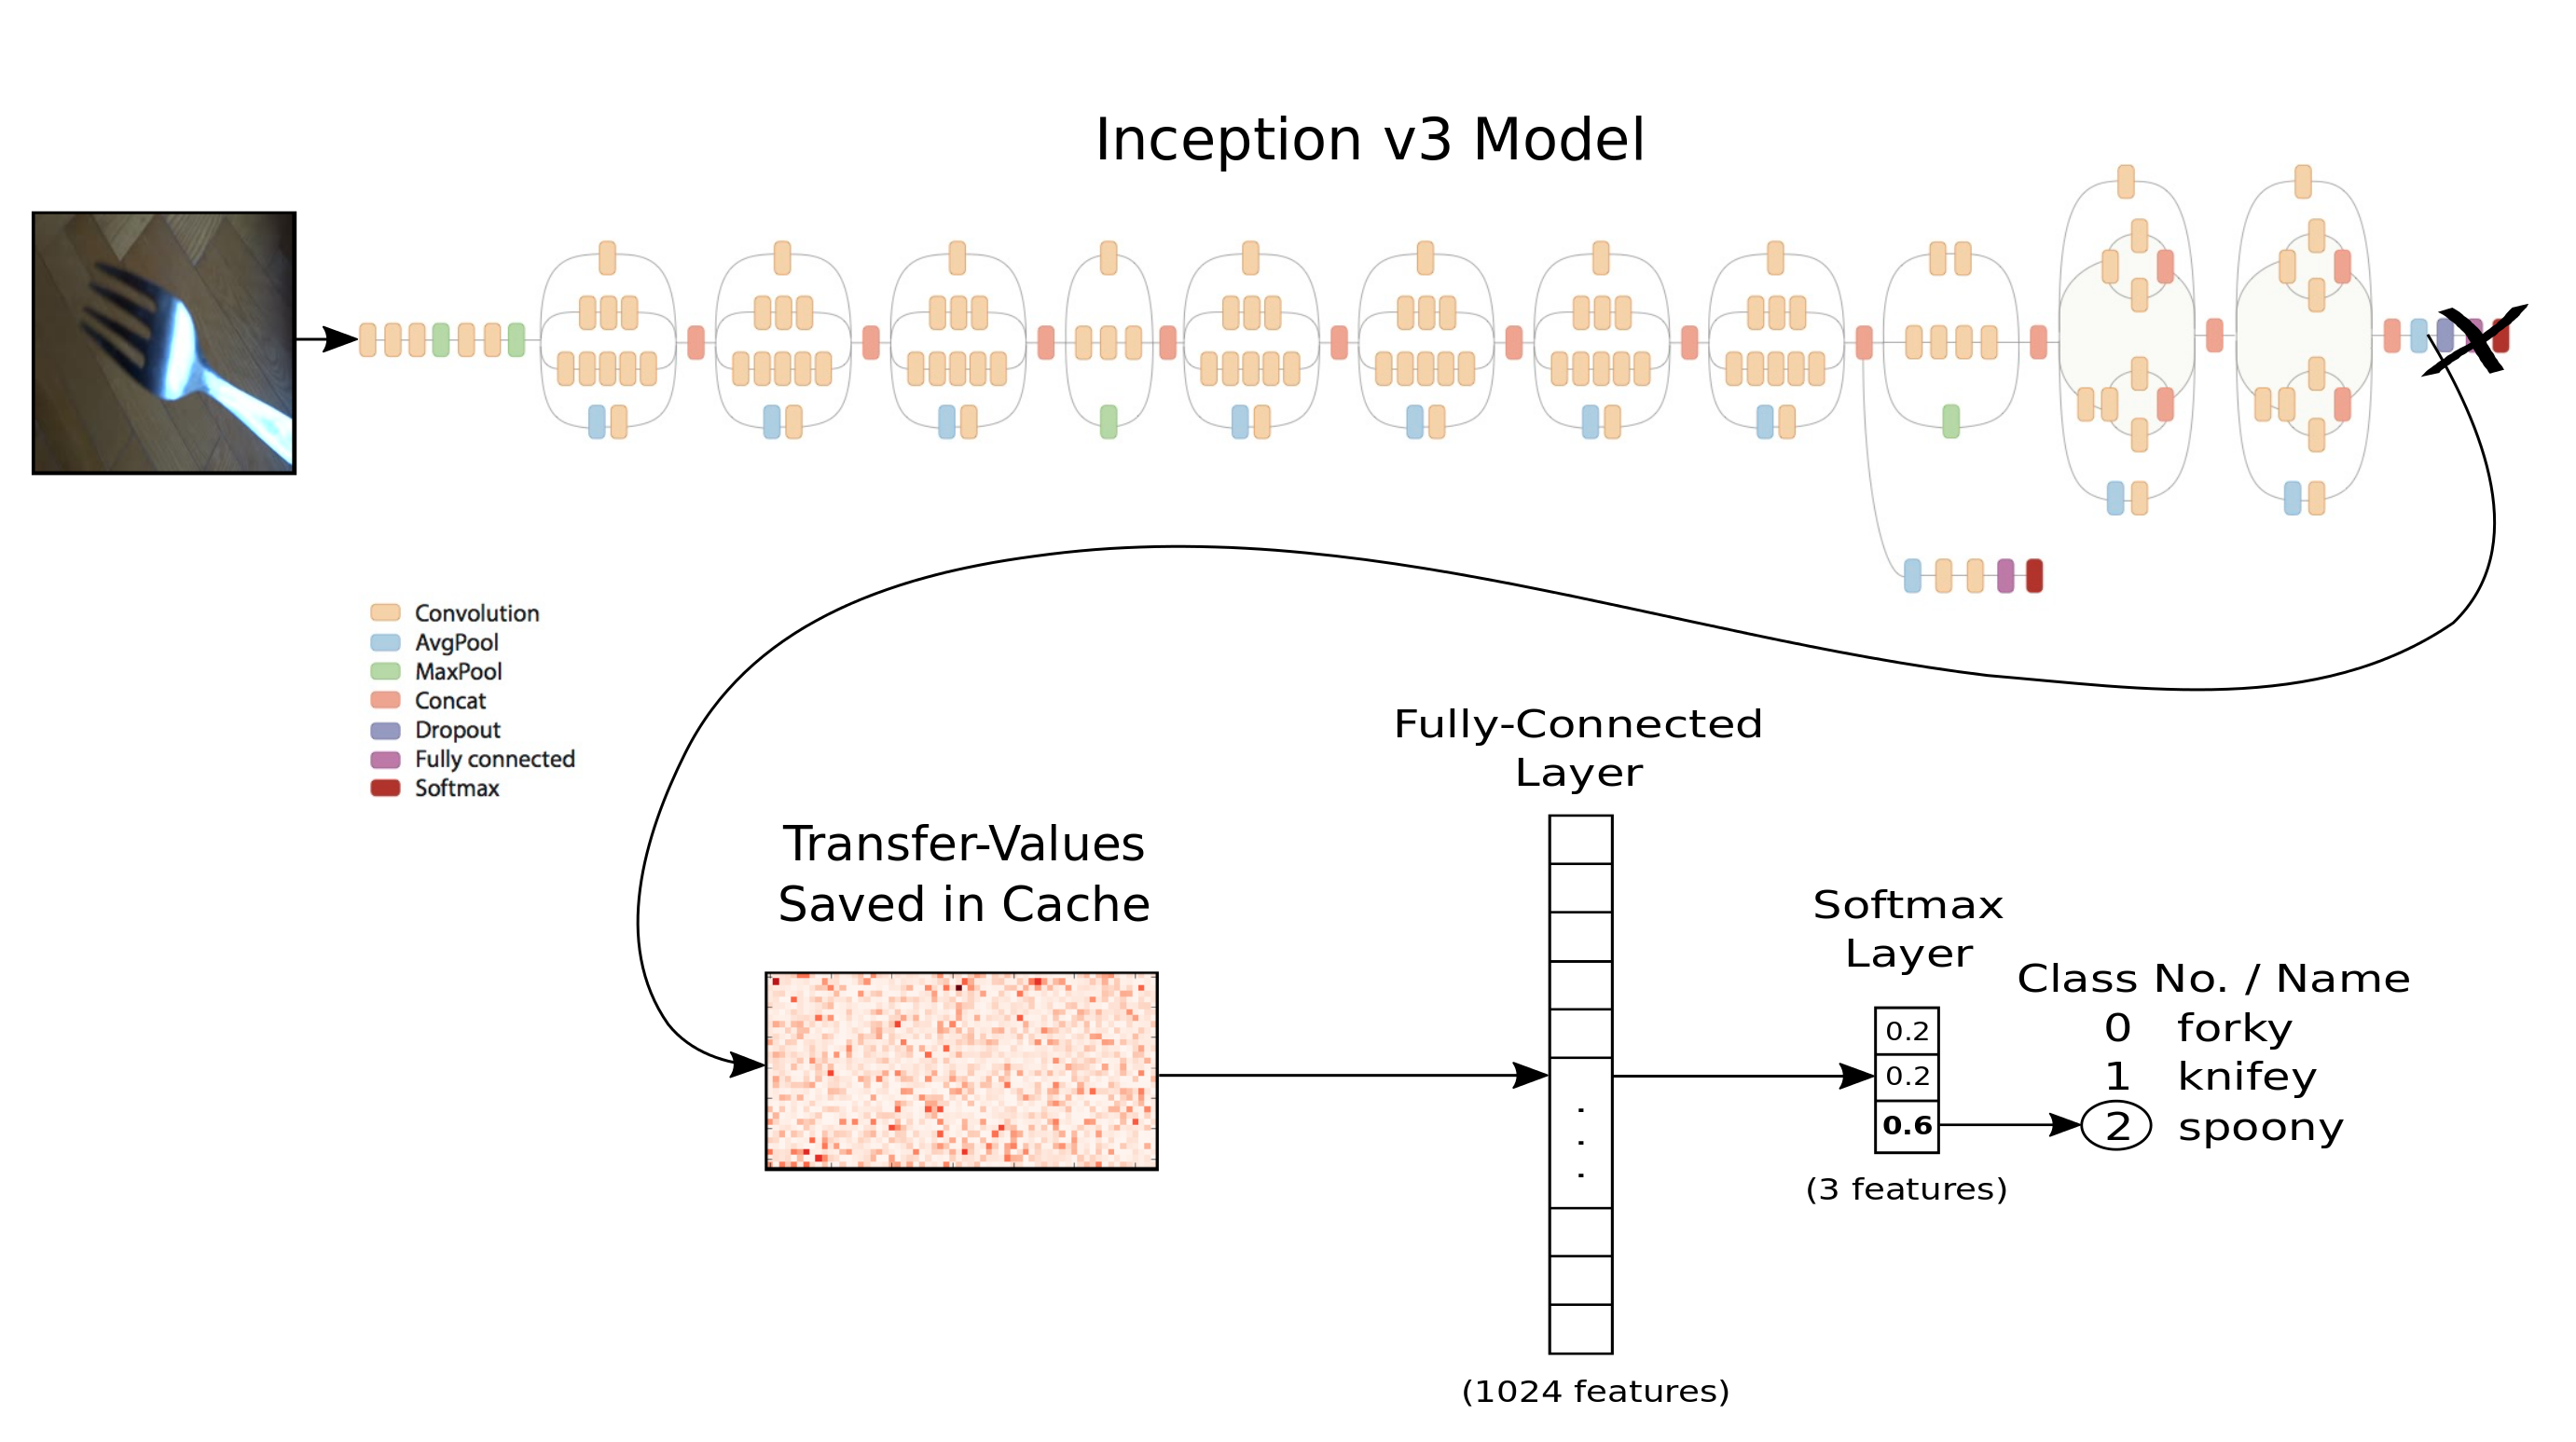

In [1]:
from IPython.display import Image, display
Image('images/09_transfer_learning_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [3]:
tf.__version__

'1.0.1'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data

In [5]:
import knifey

데이터 차원은 이미 `knifey` 모델에 정의되어 있으므로 우리는 그것을 불러오는 것이 필요하다

In [6]:
from knifey import num_classes

컴퓨터에 데이터셋을 저장하기 위한 디렉토리를 설정하라

In [7]:
# knifey.data_dir = "data/knifey-spoony/"

이 튜토리얼에서 캐쉬파일에 대해 사용할 디렉토리를 설정하라

In [8]:
data_dir = knifey.data_dir

Knifey-Spoony 데이터셋은 약 22 MB 이고 주어진 경로에 없다면 자동적으로 받아진다

In [9]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


데이터셋이 불러와졌다. 하위 디렉토리에서 모든 `*.jpg` 이미지를 검색하고 학습 데이터셋과 테스트셋에 대한 두개의 리스트 속에 파일명들을 넣는다. 이것은 실제로 이미지를 불러오지는 않는다. 아래에서 전이값을 계산할 때 사용될 것이다.

파일명의 리스트는 하드디스크에 캐쉬되어 있으므로 우리는 나중에 데이터셋을 다시 불러올 때 순서를 보장할 수 있다.
우리가 전이값이 해당하는 이미지 파일을 아는 것은 중요하다.

In [10]:
dataset = knifey.load()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl


### Your Data

knifey-spoony 데이터셋을 불러오는 것 대신 자신의 이미지를 사용할 수 있다. `dataset.py` 모듈로부터 `DataSet` 객체를 만들어야만 한다. 가장 좋은 방법은 이미지 파일의 리스트를 가지고 자동적으로 캐쉬파일을 저장하는 `load_cached()` 함수를 이용하는 것이다. 그러므로 아래에서 전이값의 순서가 변함없는 것을 보장할 수 있다.

이미지들은 각 클래스에 대해 하위 폴더로 구성되어야한다. `dataset.py` 모듈에 더 자세한 내용을 보라

In [11]:
# This is the code you would run to load your own image-files.
# It has been commented out so it won't run now.

# from dataset import load_cached
# dataset = load_cached(cache_path='my_dataset_cache.pkl', in_dir='my_images/')
# num_classes = dataset.num_classes

### Training and Test-Sets

클래스이름을 불러온다.

In [12]:
class_names = dataset.class_names
class_names

['forky', 'knifey', 'spoony']

학습데이터셋을 불러온다. 이것은 이미지, 정수로된 클래스 숫자, 라벨이라 불리는 One-Hot 인코딩된 클래스 숫자 배열을 반환한다

In [13]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

잘 불러왔는지 확인하기 위해 첫번째 이미지 경로를 출력해라

In [14]:
image_paths_train[0]

'D:\\deeplearning\\hvass-lab\\data\\knifey-spoony\\forky\\forky-01-0001.jpg'

테스트셋을 불러온다

In [15]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

잘 불러왔는지 확인하기 위해 첫번째 이미지 경로를 출력해라

In [16]:
image_paths_test[0]

'D:\\deeplearning\\hvass-lab\\data\\knifey-spoony\\forky\\test/forky-test-01-0001.jpg'

Knifey-Spoony 데이터셋은 불러와졌고, 4170 장의 이미지와 라벨로 구성되어 있다. 이 데이터셋은 학습데이터셋과 테스트셋 2개의 상호 배반적인 하위 데이터셋으로 나눠진다.

In [17]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		4170
- Test-set:		530


### Helper-function for plotting images

3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수

In [18]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true)

    # subplots로 3x3 격자 figure를 만듬
    fig, axes = plt.subplots(3, 3)

    # 각 격자의 떨어진 정도를 조정함
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # 보간법 타입
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 9개의 이미지보다 작은 경우만 한다 이것은 충돌을 막는 것을 보장한다
        if i < len(images):
            # 이미지 표시.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # 실제 클래스의 이름
            cls_true_name = class_names[cls_true[i]]

            # 실제와 예측 클래스를 보여준다
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # 예측된 클래스의 이름
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # x 축 라벨에 실제 클래스를 보여줌
            ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper-function for loading images

이 데이터셋은 실제 이미지를 불러오지 않는다 대신 이것은 학습 데이터셋 안에 이미지의 리스트와 테스트셋 안에 이미지의 리스트를 가진다. 이 도움함수는 몇몇 이미지 파일을 불러온다.

In [19]:
from matplotlib.image import imread

def load_images(image_paths):
    # 디스크로부터 이미지를 불러온다
    images = [imread(path) for path in image_paths]

    # 넘파일 배열로 바꾸고 반환
    return np.asarray(images)

### Plot a few images to see if data is correct

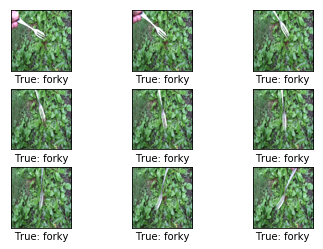

In [20]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = load_images(image_paths=image_paths_test[0:9])

# 이들 이미지의 실제 클래스값 얻음
cls_true = cls_test[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true, smooth=True)

## Download the Inception Model

인터넷으로부터 인셉션 모델을 다운받는다. 데이터파일을 저장하려는 기본 디렉토리. 이 디렉토리는 존재하지 않으면 만들어진다.

In [21]:
# inception.data_dir = 'inception/'

디렉토리에 존재하지 않으면 인셉션 모델에 대한 자료를 받는다. 이것은 85 MB.

See Tutorial #07 for more details.

In [22]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Load the Inception Model

인셉션 모델을 불러왔으므로 이미지를 분류하기 위한 준비가 되었다.

deprecation 경고는 이 프로그램이 미래에 실패할 수도 있다는 것을 나타낸다

In [23]:
model = inception.Inception()

## Calculate Transfer-Values

인셉션 모델의 전이값을 캐쉬하기 위한 도움 함수를 불러온다

In [24]:
from inception import transfer_values_cache

학습데이터셋과 테스트 데이터셋의 캐쉬를 위한 파일 경로들을 설정

In [25]:
file_path_cache_train = os.path.join(data_dir, 'inception-knifey-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-knifey-test.pkl')

In [26]:
print("Processing Inception transfer-values for training-images ...")

# 만약 전이값이 이미 계산되어 있다면 그것을 불러오고 그렇지 않다면,
# 계산하고 캐쉬파일에 저장한다
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: data/knifey-spoony/inception-knifey-train.pkl


In [27]:
print("Processing Inception transfer-values for test-images ...")

# 만약 전이값이 이미 계산되어 있다면 그것을 불러오고 그렇지 않다면,
# 계산하고 캐쉬파일에 저장한다
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: data/knifey-spoony/inception-knifey-test.pkl


전이값을 가진 배열의 모양을 확인. 학습 데이터셋에는 4,170 장의 이미지가 있고 각각 2048개의 전이 값을 가진다.

In [28]:
transfer_values_train.shape

(4170, 2048)

비슷하게, 테스트셋에는 530 장의 이미지가 있고 각각 2048개의 전이 값을 가진다.

In [29]:
transfer_values_test.shape

(530, 2048)

### Helper-function for plotting transfer-values

In [30]:
def plot_transfer_values(i):
    print("Input image:")
    
    # 테스트셋으로부터 i 번째 이미지를 그린다
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # 전이 값을 이미지로 바꾼다
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # 전이값을 이미지로 그린다
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


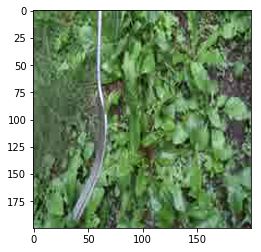

Transfer-values for the image using Inception model:


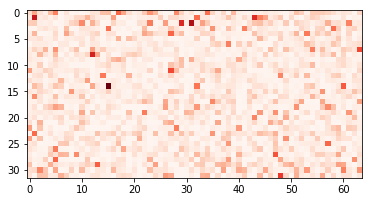

In [31]:
plot_transfer_values(i=100)

Input image:


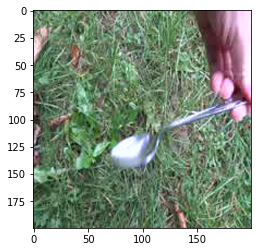

Transfer-values for the image using Inception model:


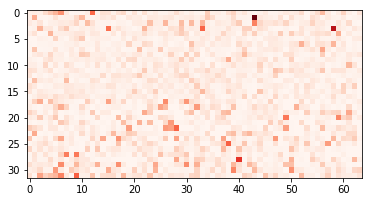

In [32]:
plot_transfer_values(i=300)

## Analysis of Transfer-Values using PCA

scikit-learn의 주성분분석(PCA, Principal Component Analysis)를 이용해 전이값 배열의 길이를 2048에서 2로 줄이면 그릴 수 있게 된다

In [33]:
from sklearn.decomposition import PCA

새 PCA 객체와 목표 배열 길이를 2로 설정한다

In [34]:
pca = PCA(n_components=2)

PCA 계산하는데 시간이 걸린다. 이 사례에서 데이터셋은 너무 크지 않지만 계산을 빨리 하기 위해 학습 데이터셋의 작은 부분을 선택할 수 있다

In [35]:
# transfer_values = transfer_values_train[0:3000]
transfer_values = transfer_values_train

선택된 샘플들에 대한 클래스 숫자를 얻는다

In [36]:
# cls = cls_train[0:3000]
cls = cls_train

각 샘플에 대한 2048 개의 전이값과 4,170개의 샘플을 가진 배열인지 확인

In [37]:
transfer_values.shape

(4170, 2048)

PCA를 사용해 전이값 배열을 2048에서 2개의 요소로 줄인다

In [38]:
transfer_values_reduced = pca.fit_transform(transfer_values)

각 샘플에 대해 2개의 값과 4,170개의 샘플을 가진 배열인지 확인

In [39]:
transfer_values_reduced.shape

(4170, 2)

줄어든 전이값을 그리기 위한 도움 함수

In [40]:
def plot_scatter(values, cls):
    # 각 클래스에 대해 다른 색깔을 갖는 컬러맵을 만든다
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # 더 나은 그림을 만들기 위해 무작위 순열을 갖는 인덱스를 만든다
    idx = np.random.permutation(len(values))
    
    # 각 샘플에 대한 색깔을 얻는다
    colors = cmap[cls[idx]]

    # x와 y 값을 추출
    x = values[idx, 0]
    y = values[idx, 1]

    # 그린다
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

PCA를 사용해 줄어든 전이값을 그린다. Knifey-Spoony 데이터셋 안에 다른 클래스에 대해 3개의 다른 색깔이 있다. 이 색깔들은 함께 그룹지어지지만 매우 넓게 겹쳐있다. 왜냐하면 PCA가 전이값을 적절히 분리할 수 없기 때문이다.

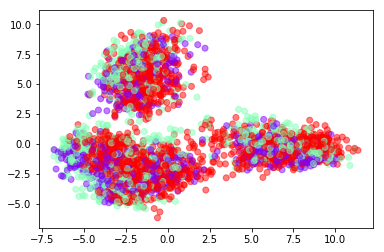

In [41]:
plot_scatter(transfer_values_reduced, cls=cls)

## Analysis of Transfer-Values using t-SNE

In [42]:
from sklearn.manifold import TSNE

차원 감소를 위한 또다른 방법은 t-SNE다. 불행하게도, t-SNE는 매우 느리기 때문에 우리는 먼저 PCA를 사용해 전이값을 2048에서 50으로 줄인다

In [43]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

최종 차원 감소를 위해 새로운 t-SNE 객체를 만들고 목표를 2차원으로 설정

In [44]:
tsne = TSNE(n_components=2)

t-SNE를 사용해 마지막 차원감소를 수행. scikit-learn 안에 t-SNE의 현재 구현은 매우 많은 데이터를 다룰 수 없으므로 만약 완전한 데이터셋을 사용한다면 멈출 것이다.

In [45]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

각 샘플에 대해 2개의 값과 4,170개의 샘플을 가진 배열인지 확인

In [46]:
transfer_values_reduced.shape

(4170, 2)

t-SNE를 사용해 2차원으로 줄어든 전이값을 그리면 위의 PCA 그림보다 더 잘 나눠지는 것을 볼 수 있다.

인셉션 모델으로부터의 전이값이 여전히 겹친 부분이 있어서 완벽하게 분리하지는 못하지만 Knifey-Spoony 이미지를 클래스 속에 분리하기 위한 충분한 정보를 포함하고 있다는 것을 의미한다

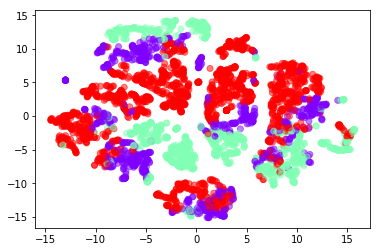

In [47]:
plot_scatter(transfer_values_reduced, cls=cls)

## New Classifier in TensorFlow

이제 우리는 텐서플로 안에 다른 신경망을 만들 것이다. 이 신경망은 인셉션 모델로부터의 전이값을 입력으로 가지고 Knifey-Spoony 이미지에 대해 예측 클래스를 출력할 것이다

이미 텐서플로에서 신경망을 만드는 방법에 익숙하다고 가정한다. 그렇지 않다면 튜토리얼 3을 보라

### Placeholder Variables

인셉션 모델 객체에서 변수로 저장되어있는 전이값에 대한 배열 길이가 필요하다

In [48]:
transfer_len = model.transfer_len

우리가 만드는 새로운 신경망 속에 인셉션 모델로부터의 전이값을 입력 받기 위한 placeholder 변수를 만든다. 이 변수의 모양은 `[None, transfer_len]` 이고 이는 변할 수 있는 샘플의 수와 샘플 당 `transfer_len`과 동일한 2048개의 요소를 갖는 입력 배열을 의미한다.

In [49]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

각 이미지의 실제 클래스 라벨을 입력받기 위한 또다른 placeholder 변수를 만든다. 이는 데이터셋에서 각 가능한 클래스 중 하나인 3개의 요소를 갖는 One-Hot 인코딩되 배열이다

In [50]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

정수로된 실제 클래스를 계산한다. 이것 역시 placeholder 변수가 될 수 있다

In [51]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

Knifey-Spoony 데이터셋에 대해 분류를 하는 신경망을 만든다. 이것은 placeholder 변수 `x`에 보낼 인셉션 모델로부터의 전이값을 입력으로 갖는다. 이 신경망은 `y_pred` 안에 예측 클래스를 출력한다

신경망을 구성하기 위해 Pretty Tensor를 사용하는 방법에 대해 더 자세한 것은 튜토리얼 3을 보라

In [52]:
# Pretty Tensor 객체로 전이값을 Wrap 한다
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Optimization Method

최적화 반복 수행의 수를 추적하기 위한 변수를 만든다

In [53]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

새로운 신경망을 최적화하기 위한 방법

In [54]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

정수인 예측 클래스 숫자를 계산한다. `y_pred`는 3 요소를 갖는 배열이다. 클래스 숫자는 이 배열에서 가장 큰 요소의 인덱스이다.

In [55]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

각 이미지의 실제 클래스와 예측 클래스가 동일한지를 나타내는 진리값 벡터를 만든다

In [56]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

correct_prediction 이 boolean 값이기 때문에 float32 형태로 가져와 정확도를 계산한다.

In [57]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow Session

텐서플로 그래프가 만들어지면, 우리는 그래프를 실행하기 위해 사용되는 텐서플로 세션을 만들어야만 한다.

In [58]:
session = tf.Session()

### Initialize Variables

최적화를 시작하기전에 새로운 신경망의 모든 변수들을 초기화해야만 한다

In [59]:
session.run(tf.global_variables_initializer())

### Helper-function to get a random training-batch

학습 데이터셋에 4,170 개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

만약 컴퓨터가 RAM 때문에 너무 느리거나 멈추면, 더 작은 수를 시도해라.

In [60]:
train_batch_size = 64

학습 데이터셋으로부터 전이값의 무작위 배치를 선택하는 함수

In [61]:
def random_batch():
    # 학습 데이터셋에서 이미지의 수(전이값)
    num_images = len(transfer_values_train)

    # 무작위 인덱스 만들기
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # 무작위 인덱스를 이용해 이미지와 라벨을 선택함.
    # 우리는 이미지 대신에 전이값을 사용
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Helper-function to perform optimization

최적화 반복을 수행함으로써 신경망 레이어의 변수들을 점진적으로 향상 시킨다. 각 반복에서 새로운 데이터 배치가 선택되고 이들 표본을 사용해 최적화기를 실행한다. 진행은 매 100번 반복마다 출력된다.

In [62]:
def optimize(num_iterations):
    # 아래에 사용된 시간을 나타내는 start_time
    start_time = time.time()

    for i in range(num_iterations):
        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본(전이값)을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        x_batch, y_true_batch = random_batch()

        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 학습 자료의 이 표본을 사용해 최적화기를 실행한다.
        # 텐서플로는 feed_dict_train에 있는 변수들을 placeholder 변수에 할당하고 실행한다.
        # global_step 값을 가져온다
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # 매 100번 반복마다와 마지막에 상태 표시
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # 학습 배치에 대한 정확도 계산
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # 상태 출력
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # 끝난 시간
    end_time = time.time()

    # 시작과 끝 시간 차이
    time_dif = end_time - start_time

    # 시간 사용 출력
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-Functions for Showing Results

### Helper-function to plot example errors

잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [63]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 print_test_accuracy() 로부터 불러와진다.
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # correct 는 테스트 셋에 모든 이미지에 대한 실제와 예측의 진리값
    
    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)

    # 올바르게 분류되지 않은 이미지를 얻는다
    idx = np.flatnonzero(incorrect)

    # 선택할 이미지의 수, 최대 9
    n = min(len(idx), 9)
    
    # 무작위로 n개의 인덱스를 선택
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[idx]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # 문자열 리스트에서 image_paths_test[idx]를 할 수 없다
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # 9개의 이미지를 나타낸다.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

### Helper-function to plot confusion matrix

In [64]:
# 혼동행렬을 계산하기 위해 sklearn 으로부터 함수를 불러온다
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # 이건 아래의 print_test_accuracy()에서 호출된다

    # cls_pred는 테스트셋에 모든 이미지에 대한 예측 클래스 숫자의 배열

    # sklearn 을 사용해 혼동 행렬을 얻는다
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # 혼동 행렬을 텍스트로 출력한다
    for i in range(num_classes):
        # 각 라인에 클래스 이름을 더한다
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

이 함수는 이미지의 예측 클래스를 계산하고, 각 이미지의 분류가 올바른지 나타내는 진리값을 반환한다

이 계산은 배치에서 수행된다 왜냐하면 RAM을 많이 사용할 수 있기 때문이다. 만약 컴퓨터가 멈춘다면 배치 사이즈를 줄이고 다시 해라

In [65]:
# 데이터를 몇개씩 나눌 것인지
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # 이미지의 수
    num_images = len(transfer_values)

    # 배치에서 계산되기 위한 예측 클래스의 배열을 할당하고 이 배열 속에 채운다.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # 배치에 대해 예측 클래스를 계산한다.
    # 모든 배치에 대해 반복할 것

    # 배치를 위한 순번 초기화
    i = 0
    
    # i가 테스트셋 숫자보다 작은 경우 계속
    while i < num_images:
        # j 는 배치의 끝 번호
        j = min(i + batch_size, num_images)

        # i부터 j까지의 이미지와 라벨을 feed_dict 으로 만든다
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # 텐서플로를 사용해 예상 클래스를 만든다
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치를 위해 i를 j로 바꾼다
        i = j
        
    # 예상 클래스와 실제 클래스를 비교한다.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

테스트 셋에 대한 예측 클래스를 계산한다

In [66]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for calculating the classification accuracy

이 함수는 각 이미지가 정확히 분류되었는지 아닌지에 대한 진리값이 주어졌을 때 분류 정확도를 계산한다.
E.g. `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [67]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the classification accuracy

테스트 셋에 대한 분류 정확도를 출력하는 함수

테스트 셋에 모든 이미지에 대한 분류를 계산한다. 결과는 이 함수로부터 직접적으로 위의 함수에 호출되어 재사용된다. 그래서 분류는 각 함수마다 재 계산되지 않는다.

In [68]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # 테스트셋에 모든 이미지에 대해 맞았는지 틀렸는지 나타낸다.
    correct, cls_pred = predict_cls_test()
    
    # 정확도를 계산한다.
    acc, num_correct = classification_accuracy(correct)
    
    # 이미지의 수
    num_images = len(correct)

    # 정확도 출력
    msg = "테스트셋에 대한 정확도: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # 원한다면 틀린 그림을 표시할 수 있다
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원한다면 혼동 행렬을 표시할 수 있다
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Results

## Performance before any optimization

테스트 셋에 대한 정확도는 매우 낮다 왜냐하면 초기화만되고 최적화되지 않았기 때문이다 그래서 이미지는 무작위로 분류되었다.

In [69]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

테스트셋에 대한 정확도: 42.5% (225 / 530)
Confusion Matrix:
[72  0 79] (0) forky
[48  0 89] (1) knifey
[ 89   0 153] (2) spoony
 (0) (1) (2)


## Performance after 1000 optimization iterations

1,000 번 최적화 반복 후에, 테스트셋에 대한 분류 정확도는 약 70%다

In [70]:
optimize(num_iterations=1000)

Global Step:    100, Training Batch Accuracy:  93.8%
Global Step:    200, Training Batch Accuracy:  96.9%
Global Step:    300, Training Batch Accuracy:  95.3%
Global Step:    400, Training Batch Accuracy: 100.0%
Global Step:    500, Training Batch Accuracy:  98.4%
Global Step:    600, Training Batch Accuracy: 100.0%
Global Step:    700, Training Batch Accuracy: 100.0%
Global Step:    800, Training Batch Accuracy: 100.0%
Global Step:    900, Training Batch Accuracy: 100.0%
Global Step:   1000, Training Batch Accuracy: 100.0%
Time usage: 0:00:02


테스트셋에 대한 정확도: 71.7% (380 / 530)
Example errors:


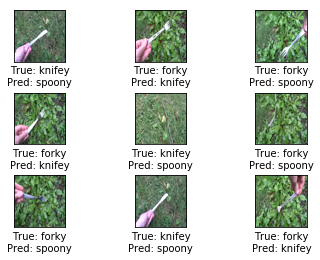

Confusion Matrix:
[42 34 75] (0) forky
[ 8 99 30] (1) knifey
[  2   1 239] (2) spoony
 (0) (1) (2)


In [71]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다. 텐서플로 세션은 model 객체 안에 있고 그래서 객체를 통해 세션을 닫는다

In [72]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# model.close()
# session.close()

## Conclusion

이 튜토리얼은 인셉션 모델을 가지고 전이 학습에서 자신의 데이터를 사용하는 법을 보인다. 이 튜토리얼에서 사용된 수천장의 이미지는 [script](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py) 를 사용해 비디오로부터 생성되었다.

그러나, 분류 정확도는 Knifey-Spoony 데이터셋에 대해 그리 좋지 않다 특히 포크에 대한 이미지에 그렇다. 이유는 인셉션 모델이 스푼 이미지는 1,200장과 1,300장이 넘는 칼 이미지인 반면 16개의 포크 이미지만을 가진 이미지넷의 데이터셋에 대해 학습이 되었기 때문일 것이다. 그러므로 인셉션 모델이 포크를 적절히 인지 못하는 것은 가능하다

그러므로 우리는 포크 이미지를 더 잘 인식하기 위해 인셉션 모델을 미세 조정할 또다른 기법이 필요하다.

## Exercises

* 새로운 분류에 대한 신경망을 바꿔보라. 완전 연결 레이어를 지우거나 완전 연결 레이어를 추가하면 무슨 일이 일어나는가?
* 최적화 반복을 덜하거나 더하면 무슨 일이 일어나는가?
* 학습 데이터셋에서 spoony 이미지의 몇몇을 지워서 3개의 클래스의 이미지 수를 비슷하게 하고 시도하라(백업 부터 하라). `*.pkl` 파일들 모든 캐쉬를 지울 필요가 있고 노트북을 재시작할 필요가 있다. 분류 정확도가 향상되는가? 전과 후의 혼동 행렬을 비교하라
* `convert.py` 스크립트를 사용해 자신의 데이터셋을 만들라. 예를 들어, 차나 바이크의 비디오를 녹화하고 두개의 클래스를 나눌 수 있는 분류 시스템을 만들라
* 만든 학습데이터셋으로부터 불분명한 이미지를 지우는 것이 필요한가? 불분명한 이미지를 지운다면 분류 정확도에 무슨 일이 일어나는가?
* 전체 데이터셋 대신 한 장의 이미지를 입력받을 수 있게 노트북을 바꿔라. 인셉션 모델로부터의 전이값을 캐쉬할 필요가 없다.
* 전이 학습을 갖는 인셉션 모델 대신에 자신의 데이터셋에 대해 더 낫고 더 빠른 신경망을 만들 수 있는가?
* 친구에게 프로그램이 어떻게 작동하는지 설명하라

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.